In [ ]:

import glob
import os
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')

import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from neuroformer.model_neuroformer import GPT, GPTConfig, neuralGPTConfig
from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils import set_seed, update_object
from neuroformer.visualize import set_plot_params
from neuroformer.SpikeVidUtils import round_n
set_plot_params()

from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from scipy.ndimage import gaussian_filter, uniform_filter

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

import argparse



set_seed(25)

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [ ]:
data_dir = "./data/VisNav_VR_Expt"

if not os.path.exists(data_dir):
    print("Downloading data...")
    import gdown
    url = "https://drive.google.com/drive/folders/117S-7NmbgrqjmjZ4QTNgoa-mx8R_yUso?usp=sharing"
    gdown.download_folder(id=url, quiet=False, use_cookies=False, output="data/")




In [ ]:
# load config files
import yaml

# base_path = "configs/visnav/predict_behavior"
base_path = "models/tensorboard/visnav/behavior_pred_exp/no_classification/window:0.05_prev:0.25/sparse_f:None_id:None/w:0.05_wp:0.25/"

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
    dconf = yaml.full_load(stream)

import omegaconf
from omegaconf import OmegaConf

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
dconf = OmegaConf.create(dconf)




In [ ]:
import mat73
import scipy

data_path = "data/VisNav_VR_Expt/experiment_data.mat"
data = mat73.loadmat(data_path)['neuroformer']

# data_response_path = "/data5/antonis/neuroformer/data/VisNav_VR_Expt/yiyi/experiment_data_selected.mat"
# data_response = scipy.io.loadmat(data_response_path)
# neurons_sel1 = "./data/VisNav_VR_Expt/yiyi/sel1.csv"
# neurons_sel1 = pd.read_csv(neurons_sel1)
# neurons_sel1 = np.array(neurons_sel1).flatten()
print(data.keys())


In [ ]:
frame_window = 0.2
window = 0.05
window_prev = 0.25
window_behavior = window
dt = 0.005
dt_frames = 0.05
dt_vars = 0.05
dt_speed = 0.2
intervals = None


In [ ]:
## choose modalities ##

# behavior
behavior = True
# behavior_vars = ['t', 'eyerad', 'phi', 'speed', 'th']
behavior_vars = ['speed']
n_behavior = len(behavior_vars)
predict_behavior = False
# stimulus
visual_stim = True




In [ ]:
from neuroformer.SpikeVidUtils import trial_df, get_df_visnav, make_intervals

stimulus = data['vid_sm']
response = data['spiketimes']['spks']
trial_data = data['trialsummary']
# response = data_response['spiketime_sel2']['spks']

print(data.keys())

df = get_df_visnav(response, trial_data, dt_vars)
# df = df[df['ID'].isin(neurons_sel1)].reset_index(drop=True)

if behavior is True:
    behavior = pd.DataFrame({k: data[k] for k in behavior_vars + ['t']})
    # rename t to time
    behavior = behavior.rename(columns={'t': 'Time'}) if behavior is not None else None
    behavior['Interval'] = make_intervals(behavior, window)
    behavior['Interval_2'] = make_intervals(behavior, window_prev)

    # prepare speed variables
    behavior['speed'] = behavior['speed'].apply(lambda x: round_n(x, dt_speed))
    dt_range_speed = behavior['speed'].min(), behavior['speed'].max()
    dt_range_speed = np.arange(dt_range_speed[0], dt_range_speed[1] + dt_speed, dt_speed)
    n_behavior = len(dt_range_speed)

    stoi_speed = { round_n(ch, dt_speed):i for i,ch in enumerate(dt_range_speed) }
    itos_speed = { i:round_n(ch, dt_speed) for i,ch in enumerate(dt_range_speed) }
    assert (window_behavior) % dt_vars < 1e-5, "window + window_prev must be divisible by dt_vars"
    samples_per_behavior = int((window + window_prev) // dt_vars)
    behavior_block_size = int((window + window_prev) // dt_vars) * (len(behavior.columns) - 1)
else:
    behavior = None
    behavior_vars = None
    behavior_block_size = 0
    samples_per_behavior = 0
    stoi_speed = None
    itos_speed = None
    dt_range_speed = None
    n_behavior = None


In [ ]:
from neuroformer.SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['real_interval'] = make_intervals(df, 0.05)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']


In [ ]:
from neuroformer.SpikeVidUtils import SpikeTimeVidData2

## resnet3d feats
n_frames = round(frame_window * 1/dt_frames)
kernel_size = (n_frames, 5, 5)
n_embd = 256
n_embd_frames = 64
frame_feats = stimulus if visual_stim else None
frame_block_size = ((n_frames // kernel_size[0] * 30 * 100) // (n_embd_frames))
frame_feats = torch.tensor(stimulus, dtype=torch.float32)
conv_layer = True

prev_id_block_size = 300
id_block_size = 100   #
block_size = frame_block_size + id_block_size + prev_id_block_size
frame_memory = frame_window // dt_frames
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

neurons = sorted(list(set(df['ID'].unique())))
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }



In [ ]:
import random

r_split = 0.8
all_trials = sorted(df['Trial'].unique())
train_trials = random.sample(all_trials, int(len(all_trials) * r_split))

train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]



In [ ]:
from neuroformer.SpikeVidUtils import SpikeTimeVidData2


train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset='visnav',
                                  behavior=behavior, behavior_vars=behavior_vars, dt_vars=dt_vars,
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior, predict_behavior=predict_behavior,
                                  stoi_speed=stoi_speed, itos_speed=itos_speed, dt_speed=dt_speed)
test_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset='visnav',
                                  behavior=behavior, behavior_vars=behavior_vars, dt_vars=dt_vars,
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior, predict_behavior=predict_behavior,
                                  stoi_speed=stoi_speed, itos_speed=itos_speed, dt_speed=dt_speed)

print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')


In [ ]:
loader = DataLoader(train_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)
iterable = iter(loader)




In [ ]:
x, y = next(iterable)
# print(x['behavior'].shape, x['behavior_dt'].shape)
for k in x.keys():
    print(k, x[k].shape)
for k in y.keys():
    print(f"y: {k}, {y[k].shape}")


In [ ]:

layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)   
max_epochs = 2000
batch_size = round((32 * 7))
shuffle = True

title =  f'no_classification_behavior_alignment'

model_path = f"""./models/tensorboard/visnav/behavior_pred_exp/multiple-contrastive/{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""

model_conf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        behavior_block_size=behavior_block_size,
                        sparse_mask=False, p_sparse=None, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(n_dt),
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=mconf.n_state_layers, n_state_history_layers=mconf.n_state_history_layers,
                        n_stimulus_layers=mconf.n_stimulus_layers, self_att_layers=mconf.self_att_layers,
                        n_behavior_layers=mconf.n_behavior_layers, predict_behavior=predict_behavior, n_behavior=n_behavior,
                        n_head=mconf.n_head, n_embd=mconf.n_embd, 
                        contrastive=True, clip_emb=1024, clip_temp=mconf.clip_temp,
                        conv_layer=conv_layer, kernel_size=kernel_size,
                        temp_emb=mconf.temp_emb, pos_emb=False,
                        id_drop=0.35, im_drop=0.35, b_drop=0.45,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt, n_embd_frames=n_embd_frames,
                        ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'])  # 0.35

# update_object(model_conf, mconf)
model_conf.contrastive_vars = ['id', 'frames', 'behavior_mean']
model = GPT(model_conf)
# model.load_state_dict(torch.load(model_path))


# # %%
# model.cpu()
# preds, features, loss = model(x, y)
# for key in loss.keys():
#     print(key, loss[key])



In [ ]:
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=1e-4, 
                    num_workers=4, lr_decay=True, patience=3, warmup_tokens=8e7, 
                    decay_weights=True, weight_decay=1.0, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, 
                    dist=False, save_every=1000)

# trainer = Trainer(model, train_dataset, test_dataset, tconf, model_conf)
# trainer.train()


In [ ]:
model.load_state_dict(torch.load(model_path))
loader = DataLoader(train_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)
iterable = iter(loader)

In [ ]:
x, y = next(iterable)
preds, features, loss = model(x, y)

In [23]:
stoi['EOS']

2202

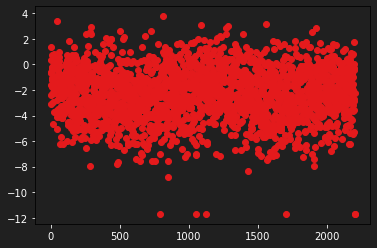

In [27]:
preds['id'].shape

pred_step = preds['id'][0, 2].detach().cpu().numpy()
x_axis = np.arange(0, len(pred_step))
plt.scatter(x_axis, pred_step)

In [ ]:
from analysis import get_rates_trial, calc_corr_psth

df_1 = df_trial
df_pred_full = df_pred

window_pred = 0.5
window_pred = window if window_pred is None else window_pred
intervals = np.array(sorted(set(df['Interval'].unique()) & set(df['Interval'].unique())))
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))

rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)

top_corr_pred = calc_corr_psth(rates_pred, rates_1)


In [ ]:
"""

Evaluate results

"""

from neuroformer.visualize import *
from neuroformer.analysis import get_accuracy


len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred, df_1)
pred_scores = compute_scores(df_1, df_pred_full)

print(f"pred: {pred_scores}")

n_bins = 30
set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title(f'PSTH Correlations (V1 + AL) {title}', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6, bins=30)
plt.legend(fontsize=20)

dir_name = os.path.dirname(model_path)
model_name = os.path.basename(model_path)

top_p = 0
save_title = f'_top_p{top_p}'
plt.savefig(os.path.join(dir_name, F'psth_corr_{save_title}_.svg'))
df_pred.to_csv(os.path.join(dir_name, F'df_pred_{save_title}_.csv'))

plot_distribution(df_1, df_pred, save_path=os.path.join(dir_name, F'psth_dist_.svg'))

total_scores = dict()
total_scores['pred'] = pred_scores

print(f"model: {title}")




In [ ]:
x, y = next(iterable)

T = len(x['id'])
P = x['pad'] - 1
T_prev = len(x['id_prev'])
P_prev = x['pad_prev'] - 4

iv = float(x['interval'])

xid = x['id'][: T - P]
xid = [itos[int(i)] for i in xid]

xid_prev = x['id_prev'][: T_prev - P_prev]
xid_prev = [itos[int(i)] for i in xid_prev]

print(f"iv: {iv}, ix+window: {iv + window} pid: {x['pid']} cid: {x['cid']}")
print(f"x: {xid}")

print(f"xid_prev: {xid_prev}")

tdiff = 0
t_var = 'Time' # 'Interval'
int_var = 'cid'
# df[(df[t_var] >= iv - tdiff) & (df[t_var] <= iv + (window + tdiff)) & (df['Trial'] == int(x['trial']))]
# df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x[int_var][1] + tdiff)) & (df['Trial'] == int(x['trial']))]
df[(df[t_var] > float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x['cid'][1] + tdiff)) & (df['Trial'] == int(x['trial']))]

# t_var = 'Time' # 'Interval'
# int_var = 'pid'
# df[(df[t_var] > round(float(x[int_var][0]), 2) - tdiff) & (df[t_var] <= round(float(x[int_var][1]), 2)) & (df['Trial'] == int(x['trial']))]








